We're going to try to build the strength of schedule metric for NCAA football and use it to estimate which team is "objectively the best" for a given year.

In [1]:
import pandas as pd

DATA = '/kaggle/input/college-football-team-stats-2002-to-january-2024/cfb_box-scores_2002-2023.csv'
df = pd.read_csv(filepath_or_buffer=DATA)
df.head()

,season,week,date,time_et,game_type,away,home,rank_away,rank_home,conf_away,...,int_away,int_home,pen_num_away,pen_yards_away,pen_num_home,pen_yards_home,possession_away,possession_home,attendance,tv
0,2002,1.0,2002-08-22,7:30 PM,regular,Colorado State,Virginia,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57120.0,NaN
1,2002,1.0,2002-08-23,8:00 PM,regular,Fresno State,Wisconsin,NaN,25.0,wac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75136.0,NaN
2,2002,1.0,2002-08-24,2:30 PM,regular,Texas Tech,Ohio State,NaN,13.0,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100037.0,NaN
3,2002,1.0,2002-08-24,4:30 PM,regular,New Mexico,NC State,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47018.0,NaN
4,2002,1.0,2002-08-24,7:45 PM,regular,Arizona State,Nebraska,NaN,10.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77779.0,NaN


How big is our dataset?

<Axes: xlabel='season'>

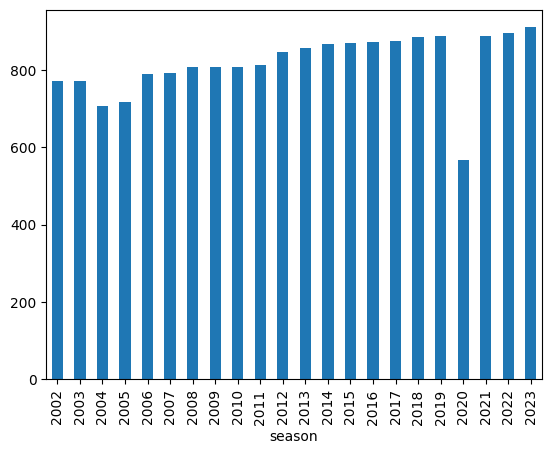

In [2]:
df['season'].value_counts().sort_index().plot(kind='bar')

We have roughly 800 games a year for 21 years; that's a lot of games.

Let's get just the win/loss figures first, and put them in a separate DataFrame.

In [3]:
win_loss_df = df[['season', 'home', 'away', 'score_away', 'score_home']].copy()
win_loss_df['winner'] = win_loss_df.apply(axis='columns', func=lambda x: 'home' if x['score_home'] > x['score_away'] else 'away')
win_loss_df['W'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] > x['score_away'] else x['away'])
win_loss_df['L'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] < x['score_away'] else x['away'])

Which teams have the most losses over the period of interest?

In [4]:
win_loss_df['L'].value_counts().head(n=10).to_frame().T

L,UNLV,New Mexico State,Kansas,Akron,Eastern Michigan,UTEP,Vanderbilt,UL-Monroe,New Mexico,Illinois
count,182,182,177,176,176,174,174,170,170,168


Which teams have the most wins over the period of interest?

In [5]:
win_loss_df['W'].value_counts().head(n=10).to_frame().T

W,Ohio State,Alabama,Georgia,Oklahoma,Boise State,Clemson,LSU,USC,Oregon,Wisconsin
count,244,243,232,231,231,220,216,205,203,202


The problem we're trying to solve here goes like this:
* There are more than 130 FBS teams and only ten weeks, so it is impossible to have every pair of teams play a game
* This means that in a given season there may be multiple undefeated teams
* And of course there may be one-loss or two-loss teams that are probably better than one or more of the undefeated teams
Strength of schedule is one metric that attempts to weight the fact that some teams play a schedule of better teams than others.

In this workbook we are going to look at two metrics described here: https://en.wikipedia.org/wiki/Strength_of_schedule


Let's collect each year into its own DataFrame. This will make it easier to calculate each team's results for each season below.

In [6]:
wl = {season: win_loss_df[win_loss_df['season'] == season] for season in win_loss_df['season'].unique().tolist()}

How many distinct home teams do we have?

In [7]:
df['home'].nunique()

139

One of the difficulties with this dataset is that it includes games where an FBS team schedules an FCS team for an early-season win, and probably other complicated situations. We have rather more away teams than home teams, and we have home teams that appear a suspiciously small number of times. 

Let's build the dataset we really want: for each season and team, let's find the games, wins, and losses.

In [8]:
records = []
teams = df['home'].unique().tolist()
for team in teams:
    for season in range(2002, 2023):
        wins = 0
        games = 0
        home_df = wl[season][wl[season]['home'] == team]
        wins += len(home_df[home_df['winner'] == 'home'])
        games += len(home_df)
        away_df = wl[season][wl[season]['away'] == team]
        wins += len(away_df[away_df['winner'] == 'away'])
        games += len(away_df)
        losses = games - wins
        records.append(pd.Series(data={'season': season, 'team': team, 'games': games, 'wins': wins, 'losses': losses, } ))
records_df = pd.DataFrame(data=records)
records_df['WPCT'] = records_df['wins']/records_df['games']
records_df.sample(n=5, random_state=2023)

,season,team,games,wins,losses,WPCT
24,2005,Wisconsin,13,10,3,0.769231
2018,2004,North Texas,12,7,5,0.583333
595,2009,Purdue,12,5,7,0.416667
2244,2020,TCU,10,6,4,0.600000
820,2003,Duke,12,4,8,0.333333


What do we expect winning percentage to look like? If our dataset only included teams with full-season records, we would expect it to have a mean of exactly 0.5.

<Axes: xlabel='WPCT', ylabel='Count'>

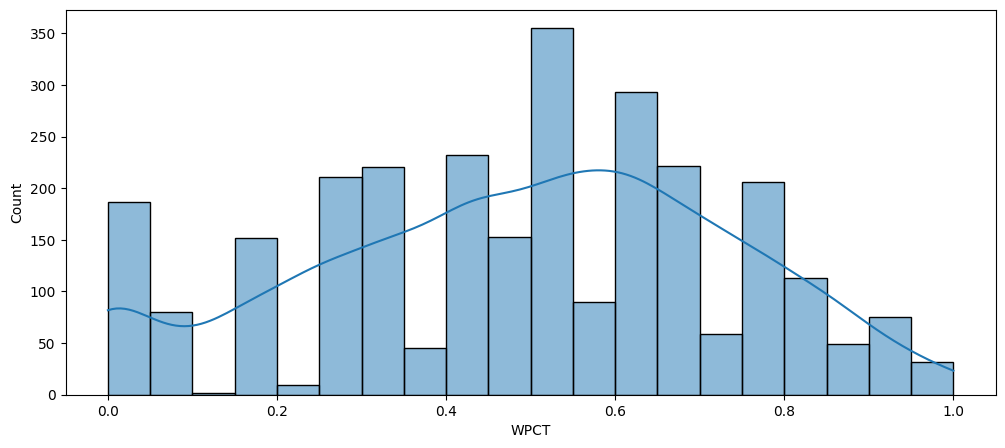

In [9]:
import matplotlib.pyplot as plt
from seaborn import histplot
from warnings import filterwarnings

filterwarnings(action='ignore', category=FutureWarning)

FIGSIZE = (12, 5)
plt.figure(figsize=FIGSIZE)
histplot(data=records_df, x='WPCT', kde=True)

Our distribution looks weird because for the most part winning percentage steps up discretely.

In [10]:
records_df['WPCT'].mean(), records_df['WPCT'].std()

(0.48731816953799717, 0.24809550575607558)

Now we're ready to calculate opponents records using this DataFrame.

In [11]:
result = []
for team in teams:
    for season in range(2002, 2023):
        home_df = wl[season][wl[season]['home'] == team]
        home_winner_df = home_df[home_df['winner'] == 'home']
        away_df = wl[season][wl[season]['away'] == team]
        away_winner_df = away_df[away_df['winner'] == 'away']
        opponents = home_df['away'].tolist() + away_df['home'].tolist()
        win_opponents = home_winner_df['away'].tolist() + away_winner_df['home'].tolist()
        opponents_df = records_df[(records_df['team'].isin(opponents)) & (records_df['season'] == season)]
        opponents_wins_df = records_df[(records_df['team'].isin(win_opponents)) & (records_df['season'] == season)]
        result.append(pd.Series(
            data={'team': team, 'season': season, 'opponent games': opponents_df['games'].sum(), 'opponent wins': opponents_df['wins'].sum(),
                 'win opponent games': opponents_wins_df['games'].sum(), 'win opponent wins': opponents_wins_df['wins'].sum(), }))        
result_df = pd.DataFrame(data=result)
result_df['SOS'] = result_df['opponent wins'] / result_df['opponent games']
result_df['SOW'] = result_df['win opponent wins'] / result_df['win opponent games']
result_df['SOW'] = result_df['SOW'].fillna(value=0.0)
result_df.sample(n=5, random_state=2024)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW
1936,Ohio,2006,164,75,98,33,0.457317,0.336735
2619,UTSA,2017,127,52,61,12,0.409449,0.196721
502,Iowa,2021,179,93,126,53,0.519553,0.420635
1957,LSU,2006,165,94,138,70,0.569697,0.507246
319,Western Michigan,2006,163,70,97,31,0.429448,0.319588


First let's take a look at the distribution of SOS. We expect it to have a mean of 0.5, but how much variance do we expect?

<Axes: xlabel='SOS', ylabel='Count'>

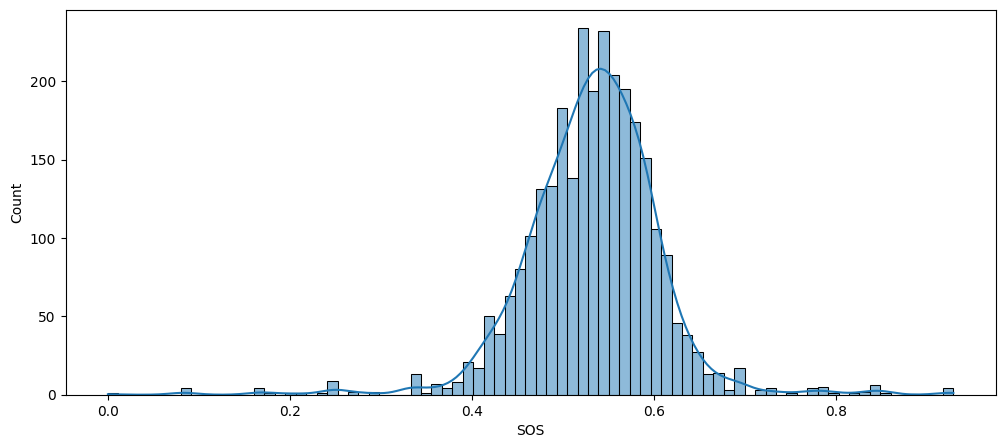

In [12]:
plt.figure(figsize=FIGSIZE)
histplot(data=result_df, x='SOS', kde=True)

In [13]:
result_df['SOS'].mean(), result_df['SOS'].std()

(0.5322307967644311, 0.07408306146505)

Our mean SOS is higher than 0.5. Why would that be? It's hard to say. We have nearly 3000 instances, so we would expect our distribution to be smoother than it is. Maybe we should see if we have some teams that only appear a few times and introduce some skew because their schedules include so few games.

<Axes: xlabel='SOW', ylabel='Count'>

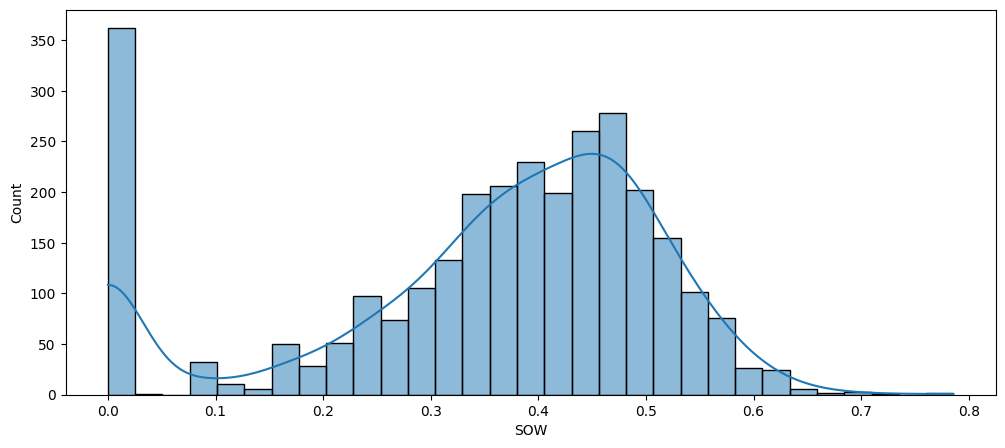

In [14]:
plt.figure(figsize=FIGSIZE)
histplot(data=result_df, x='SOW', kde=True)

In [15]:
result_df['SOW'].mean(), result_df['SOW'].std()

(0.35198374545669386, 0.16736170316605314)

Let's look at some top SOS and SOW teams.

In [16]:
result_df[result_df['opponent games'] > 100].sort_values(ascending=False, by=['SOS']).head(n=5)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW
1088,South Carolina,2019,145,101,39,23,0.696552,0.589744
2170,Mississippi State,2009,146,101,51,28,0.691781,0.549020
754,Indiana,2021,149,103,16,9,0.691275,0.562500
1233,Maryland,2017,142,98,37,17,0.690141,0.459459
1816,Missouri,2012,147,101,52,25,0.687075,0.480769


SOS/SOW by themselves do not tell us which teams are better than others; we need to add back winning percentage.

In [17]:
final_df = result_df.merge(right=records_df, on=['team', 'season'])
final_df.sample(n=5, random_state=2024)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW,games,wins,losses,WPCT
1936,Ohio,2006,164,75,98,33,0.457317,0.336735,14,9,5,0.642857
2619,UTSA,2017,127,52,61,12,0.409449,0.196721,11,6,5,0.545455
502,Iowa,2021,179,93,126,53,0.519553,0.420635,14,10,4,0.714286
1957,LSU,2006,165,94,138,70,0.569697,0.507246,13,11,2,0.846154
319,Western Michigan,2006,163,70,97,31,0.429448,0.319588,13,8,5,0.615385


Now let's add a couple of geometric means.

In [18]:
import numpy as np
final_df['WS'] = final_df.apply(axis='columns', func=lambda x: np.sqrt(x['WPCT'] * x['SOS']))
final_df['WW'] = final_df.apply(axis='columns', func=lambda x: np.sqrt(x['WPCT'] * x['SOW']))
final_df.sample(n=5, random_state=2024)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW,games,wins,losses,WPCT,WS,WW
1936,Ohio,2006,164,75,98,33,0.457317,0.336735,14,9,5,0.642857,0.542208,0.465266
2619,UTSA,2017,127,52,61,12,0.409449,0.196721,11,6,5,0.545455,0.472584,0.327571
502,Iowa,2021,179,93,126,53,0.519553,0.420635,14,10,4,0.714286,0.609187,0.548136
1957,LSU,2006,165,94,138,70,0.569697,0.507246,13,11,2,0.846154,0.694299,0.655140
319,Western Michigan,2006,163,70,97,31,0.429448,0.319588,13,8,5,0.615385,0.514077,0.443474


Let's see what teams are best by these metrics.

In [19]:
final_df[final_df['games'] > 6].sort_values(ascending=False, by=['WS']).head(n=10)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW,games,wins,losses,WPCT,WS,WW
538,Alabama,2015,185,125,172,115,0.675676,0.668605,15,14,1,0.933333,0.794123,0.789956
1633,Clemson,2018,182,114,182,114,0.626374,0.626374,15,15,0,1.000000,0.791438,0.791438
1970,LSU,2019,183,114,183,114,0.622951,0.622951,15,15,0,1.000000,0.789272,0.789272
1133,Georgia,2022,181,111,181,111,0.613260,0.613260,15,15,0,1.000000,0.783109,0.783109
1631,Clemson,2016,184,120,171,112,0.652174,0.654971,15,14,1,0.933333,0.780189,0.781861
532,Alabama,2009,168,101,168,101,0.601190,0.601190,14,14,0,1.000000,0.775365,0.775365
1709,Auburn,2010,154,92,154,92,0.597403,0.597403,14,14,0,1.000000,0.772918,0.772918
539,Alabama,2016,183,117,168,103,0.639344,0.613095,15,14,1,0.933333,0.772477,0.756454
865,Florida,2006,169,108,156,97,0.639053,0.621795,14,13,1,0.928571,0.770329,0.759856
1962,LSU,2011,154,96,154,96,0.623377,0.623377,14,13,1,0.928571,0.760822,0.760822


In [20]:
final_df[final_df['games'] > 6].sort_values(ascending=False, by=['WW']).head(n=10)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW,games,wins,losses,WPCT,WS,WW
1633,Clemson,2018,182,114,182,114,0.626374,0.626374,15,15,0,1.000000,0.791438,0.791438
538,Alabama,2015,185,125,172,115,0.675676,0.668605,15,14,1,0.933333,0.794123,0.789956
1970,LSU,2019,183,114,183,114,0.622951,0.622951,15,15,0,1.000000,0.789272,0.789272
1133,Georgia,2022,181,111,181,111,0.613260,0.613260,15,15,0,1.000000,0.783109,0.783109
1631,Clemson,2016,184,120,171,112,0.652174,0.654971,15,14,1,0.933333,0.780189,0.781861
532,Alabama,2009,168,101,168,101,0.601190,0.601190,14,14,0,1.000000,0.775365,0.775365
1709,Auburn,2010,154,92,154,92,0.597403,0.597403,14,14,0,1.000000,0.772918,0.772918
1962,LSU,2011,154,96,154,96,0.623377,0.623377,14,13,1,0.928571,0.760822,0.760822
543,Alabama,2020,135,78,135,78,0.577778,0.577778,13,13,0,1.000000,0.760117,0.760117
865,Florida,2006,169,108,156,97,0.639053,0.621795,14,13,1,0.928571,0.770329,0.759856


These look pretty good: the teams with great records from power conferences have risen to the top. Now we can pick out the top teams from any year based on these two metrics.

In [21]:
final_df[(final_df['season'] == 2022) & (final_df['games'] > 6)].sort_values(ascending=False, by=['WS']).head(n=20)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW,games,wins,losses,WPCT,WS,WW
1133,Georgia,2022,181,111,181,111,0.613260,0.613260,15,15,0,1.000000,0.783109,0.783109
776,Tennessee,2022,157,95,129,72,0.605096,0.558140,13,11,2,0.846154,0.715544,0.687220
482,Michigan,2022,180,96,165,83,0.533333,0.503030,14,13,1,0.928571,0.703732,0.683447
2246,TCU,2022,170,96,155,81,0.564706,0.522581,15,13,2,0.866667,0.699580,0.672981
62,Ohio State,2022,168,97,139,69,0.577381,0.496403,13,11,2,0.846154,0.698966,0.648100
545,Alabama,2022,154,88,127,67,0.571429,0.527559,13,11,2,0.846154,0.695353,0.668129
2267,Troy,2022,166,92,141,78,0.554217,0.553191,14,12,2,0.857143,0.689234,0.688596
524,Penn State,2022,167,92,140,68,0.550898,0.485714,13,11,2,0.846154,0.682748,0.641084
692,Tulane,2022,156,83,143,76,0.532051,0.531469,14,12,2,0.857143,0.675310,0.674940
860,Oregon,2022,156,92,115,56,0.589744,0.486957,13,10,3,0.769231,0.673535,0.612031


In [22]:
final_df[(final_df['season'] == 2022) & (final_df['games'] > 6)].sort_values(ascending=False, by=['WW']).head(n=20)

,team,season,opponent games,opponent wins,win opponent games,win opponent wins,SOS,SOW,games,wins,losses,WPCT,WS,WW
1133,Georgia,2022,181,111,181,111,0.613260,0.613260,15,15,0,1.000000,0.783109,0.783109
2267,Troy,2022,166,92,141,78,0.554217,0.553191,14,12,2,0.857143,0.689234,0.688596
776,Tennessee,2022,157,95,129,72,0.605096,0.558140,13,11,2,0.846154,0.715544,0.687220
482,Michigan,2022,180,96,165,83,0.533333,0.503030,14,13,1,0.928571,0.703732,0.683447
692,Tulane,2022,156,83,143,76,0.532051,0.531469,14,12,2,0.857143,0.675310,0.674940
2246,TCU,2022,170,96,155,81,0.564706,0.522581,15,13,2,0.866667,0.699580,0.672981
545,Alabama,2022,154,88,127,67,0.571429,0.527559,13,11,2,0.846154,0.695353,0.668129
62,Ohio State,2022,168,97,139,69,0.577381,0.496403,13,11,2,0.846154,0.698966,0.648100
524,Penn State,2022,167,92,140,68,0.550898,0.485714,13,11,2,0.846154,0.682748,0.641084
1637,Clemson,2022,166,94,127,66,0.566265,0.519685,14,11,3,0.785714,0.667025,0.639002


How did we do? Did we reproduce any of the final polls from 2022? No of course not. Both metrics do reasonably well for putting better teams ahead of worse teams and sorting out better two-loss teams from probably worse one-loss teams, etc. but neither one reproduces any of the final polls exactly. I mean just look at Troy. Troy barely cracked the top 20 of the final AP poll, but we've got them second-best. Boo.

Maybe a graph would be better. A scatter plot would probably do a better job of driving home the point that strict rankings of teams who haven't played each other is always fraught.

<Axes: xlabel='WS', ylabel='WW'>

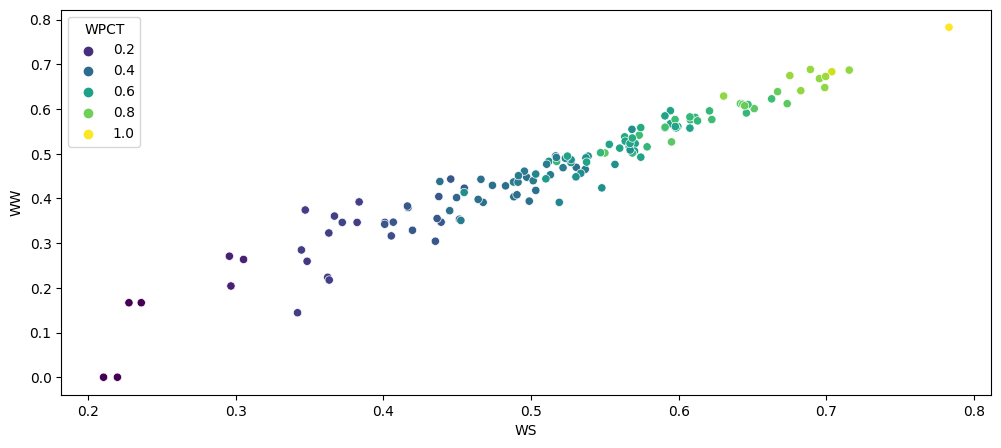

In [23]:
from seaborn import scatterplot

plt.figure(figsize=FIGSIZE)
scatterplot(palette='viridis', data=final_df[(final_df['season'] == 2022) & (final_df['games'] > 2)], x='WS', y='WW', hue='WPCT')

Our two metrics tend to produce similar results at the high end, but differ more substantially at the low end. This is probably not surprising.